# Emotion Recognition from Speech

### Requirments

In [18]:
!pip install librosa numpy pandas scikit-learn tensorflow matplotlib resampy

You should consider upgrading via the 'e:\code-alpha\venv\scripts\python.exe -m pip install --upgrade pip' command.


### 1- Extract Features (MFCCs)

In [1]:
import librosa
import numpy as np
import os

def extract_features(file_path, max_len=174):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Padding
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
        
    return mfccs


### Prepare Dataset and Labels

In [2]:
import pandas as pd

DATA_PATH = 'E:\code-alpha\Task1\Audio_Song_Actors_01-24\Actor_01'  # Change to your dataset path

emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def load_data():
    features, labels = [], []
    for file in os.listdir(DATA_PATH):
        if file.endswith('.wav'):
            emotion_code = file.split('-')[2]
            label = emotion_map.get(emotion_code)
            if label:
                mfccs = extract_features(os.path.join(DATA_PATH, file))
                features.append(mfccs)
                labels.append(label)
    return np.array(features), np.array(labels)

X, y = load_data()
print("Data Loaded: ", X.shape, y.shape)


Data Loaded:  (44, 40, 174) (44,)


### Encode Labels and Split Dataset

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X = X[..., np.newaxis]  # Add channel dimension
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


### Build Deep Learning Model (CNN + LSTM)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, Dropout, Reshape

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(40, 174, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# This reshapes automatically for LSTM
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 38, 172, 32)       320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 86, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 19, 86, 32)        0         
                                                                 
 time_distributed (TimeDist  (None, 19, 2752)          0         
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 128)               1475072   
                                                                 
 dropout_2 (Dropout)         (None, 128)              

### Train the Model

In [6]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
2/2 [==============================] - 4s 873ms/step - loss: 1.8820 - accuracy: 0.2000 - val_loss: 1.8638 - val_accuracy: 0.2222
Epoch 2/40
2/2 [==============================] - 0s 160ms/step - loss: 1.7068 - accuracy: 0.2857 - val_loss: 1.8043 - val_accuracy: 0.1111
Epoch 3/40
2/2 [==============================] - 0s 168ms/step - loss: 1.6565 - accuracy: 0.3429 - val_loss: 1.7457 - val_accuracy: 0.2222
Epoch 4/40
2/2 [==============================] - 0s 171ms/step - loss: 1.5935 - accuracy: 0.4571 - val_loss: 1.7476 - val_accuracy: 0.2222
Epoch 5/40
2/2 [==============================] - 0s 210ms/step - loss: 1.4722 - accuracy: 0.5143 - val_loss: 1.7463 - val_accuracy: 0.2222
Epoch 6/40
2/2 [==============================] - 0s 162ms/step - loss: 1.5895 - accuracy: 0.4571 - val_loss: 1.7143 - val_accuracy: 0.2222
Epoch 7/40
2/2 [==============================] - 0s 158ms/step - loss: 1.4497 - accuracy: 0.4571 - val_loss: 1.7799 - val_accuracy: 0.1111
Epoch 8/40
2/2 [====

### Evaluate the Model

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 30ms/step - loss: 1.1518 - accuracy: 0.4444
Test Accuracy: 44.44%


### Plot Training History (Optional)

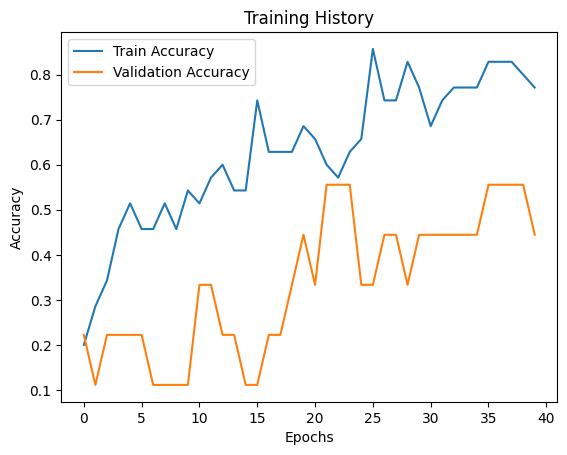

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()


### Predict on New Audio

In [10]:
def predict_emotion(file_path):
    mfccs = extract_features(file_path)
    mfccs = mfccs[np.newaxis, ..., np.newaxis]
    prediction = model.predict(mfccs)
    predicted_label = le.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example
print(predict_emotion('E:/code-alpha/Task1/Audio_Song_Actors_01-24/Actor_02/03-02-01-01-01-01-02.wav'))

1/1 [==============================] - 1s 542ms/step
angry


### Notes:
- We can switch to TESS or EMO-DB by adjusting the file parsing logic and label map.
- For better results, consider:
    - Data augmentation (noise, pitch shift).
    - Using attention mechanisms.
    - Transfer learning on audio models like YAMNet or Wav2Vec2.